# Optimization

We're often interested in the best-fitting model to some data. On Day 3, we introduced the concept of a likelihood and least-squares fitting. For linear models, we can do that in one step because the problem is uniquely determined. Today we will introduce how to fit functions that have non-linear parameters.


## Gradients!

We will assume the we know the likelihood $\mathcal{L}$ (e.g. a Gaussian), which means that we have a function that is maximized with the choice of good parameters. The function we normally work with is

$$
f(x) = - \log\mathcal{L}(x\mid\mathcal{D})
$$

which we then minimize. The log is there to remove the exponentials in many likelihoods. For example, for the ordinary least-squares solution, $f=\chi^2$.

> Mind the sign!
> It's *very* common to write down a model, optimize it, and then get some nonsense fit from the Minimum-Likelihood™ parameters.

The variable $x$ stands for the parameter we want to find the optimal value for. Notice that we don't require it to have any specific relation (for instance linear). Instead, we will demand that $f(x)$ represents a well-behaved function: we can expect derivatives of $f$ to exist everywhere in the region of interest. We can thus write down the **Taylor series** expansion for $f$ about some point $x_0$:

$$
f (x) = f (x_0) + g(x_0) (x - x_0) + \frac{1}{2} H(x_0) (x - x_0)^2 + \mathcal{O}((x-x_0)^3)
$$

where $g$ is the gradient, i.e. $g \equiv df(x)/dx$, and the **Hessian** $H$ is $H \equiv d^2 f(x) / dx^2$.

Although we don't know anything a priori about the convergence of this series, it is clear that as the distance $x - x_0$ becomes smaller, the higher-order terms become less important.

The first term of the above series is constant, so it will not tell much about where to look for a minimum. The second term is proportional to the gradient, telling in which direction the function is decreasing fastest, but it doesn't tell us what step size to take.

A first-order gradient descent method thus is typically a fixed-point iteration of the kind

$$
x_{t+1} = x_t - \lambda_t g(x_t)
$$

At iteration $t$, it goes downhill by a certain amount $\lambda_t$, which yet needs to be determined; setting it properly may require experience in the dark arts.


The third, or quadratic term describes a parabolic behavior and is therefore the lowest-order term to predict a minimum. Unlike $g$, we can expect $H$ to be roughly constant over small regions because it's variations are of higher-order (and in the case of a true parabola: identically zero).

Thus second-order gradient descent (also called **Newton methods**) have fixed-point iterations of the form

$$
x_{t+1} = x_t - H^{-1}(x_t) g(x_t)
$$

We'll see why in a minute. This means that the optimal step size for a quadratic approximation of the function $f$ is given by the inverse curvature of $f$. That sounds intuitive enough, but let's have a picture anyway.

In [48]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

# two parabolae
f = lambda x, c: c*x**2
c = 1, 0.5

# initial point
x_ = -0.75
y_ = [ f(x_, ci) for ci in c ]

# compute gradient and hessian
g = [ 2*c[i]*x_ for i in range(2) ]
H = [ 2*c[i] for i in range(2) ]

# Newton step
x__ = [ x_ - 1/H[i]*g[i] for i in range(2) ]
y__ = [ f(xi, ci) for xi, ci in zip(x__, c) ]

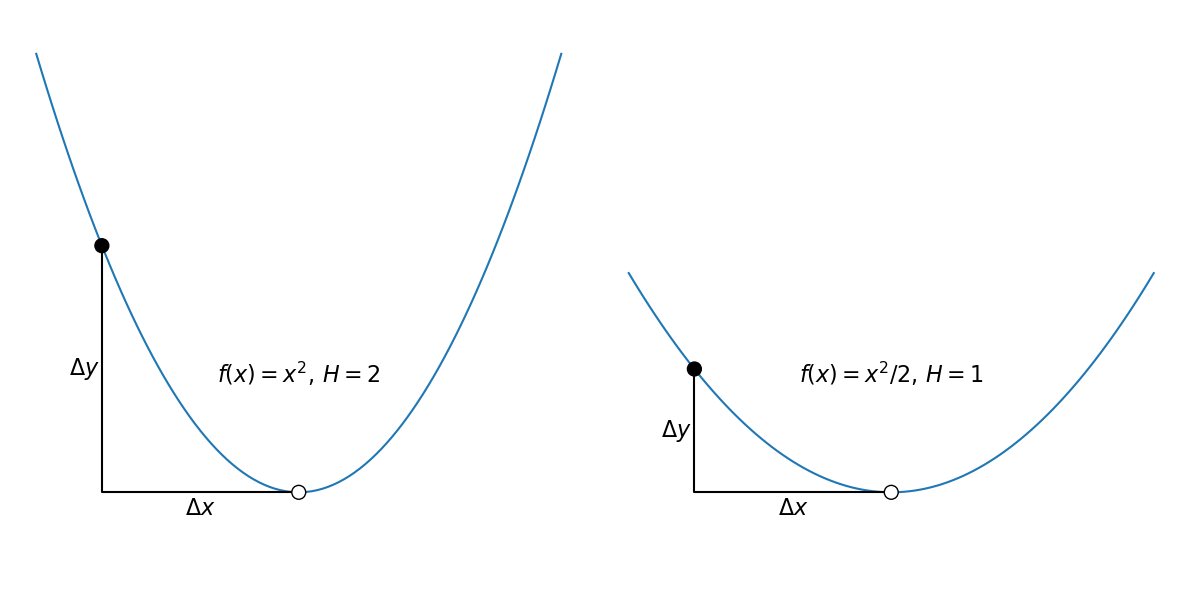

In [49]:
# plotting
x = np.linspace(-1,1,100)
fig, axes = plt.subplots(1, 2, figsize=(12,6))
axes[0].plot(x, f(x, c[0]))
axes[1].plot(x, f(x, c[1]))
axes[0].axis('off')
axes[1].axis('off')
axes[0].scatter([x_, x__[0]], [y_[0], y__[0]], c=['k', 'w'], ec='k', s=100, zorder=10)
axes[0].plot([x_, x_, x__[0]], [y_[0], y__[0], y__[0]], c='k')
axes[1].scatter([x_, x__[1]], [y_[1], y__[1]], c=['k', 'w'], ec='k', s=100, zorder=10)
axes[1].plot([x_, x_, x__[1]], [y_[1], y__[1], y__[1]], c='k')
axes[0].text(0,0.25,'$f(x)=x^2,\,H=2$', ha='center', size=16)
axes[1].text(0,0.25,'$f(x)=x^2/2,\,H=1$', ha='center', size=16)
axes[0].text(x_/2, x__[0]-0.01, '$\Delta x$', ha='center', va='top', size=16)
axes[1].text(x_/2, x__[1]-0.01, '$\Delta x$', ha='center', va='top', size=16)
axes[0].text(x_-0.01, y_[0]/2, '$\Delta y$', ha='right', va='center', size=16)
axes[1].text(x_-0.01, y_[1]/2, '$\Delta y$', ha='right', va='center', size=16)
axes[0].set_ylim(-0.2,1.1)
axes[1].set_ylim(-0.2,1.1)
fig.tight_layout()

Despite having different slopes at the starting position (filled circle), the Newton scheme performs only a single step (open circle) to move to the exact minimum, from any starting position, *if the function is quadratic*. This is even more useful because 

> Any smooth function close to its minimum looks like a quadratic function!

That's a consequence of the Taylor expansion because the first-order term $g$ vanishes close to the minimum, so all deviations from the quadratic form are of order 3 or higher in $x-x_0$.

So, why doesn't everyone compute the Hessian for optimization. Well, it's typically expensive to compute a second derivative. And in $d$ dimensions (one for each parameter), the Hessian is a matrix with $d(d+1)/2$ elements. This is why there are several **quasi-Newton methods** like [BFGS](https://en.wikipedia.org/wiki/Broyden%E2%80%93Fletcher%E2%80%93Goldfarb%E2%80%93Shanno_algorithm), that accumulate information from previous iterations into an estimate of $H$.

## Newton's Method for finding a root

[Newton's method](https://en.wikipedia.org/wiki/Newton's_method) was initially designed to find the root of a function, not its minimum. So, let's find out how these two are connected.

The central idea is to approximate $f$ by its tangent at some initial position $x_0$:

$$
y =  f(x_0) + g(x_0) (x-x_0)
$$

As we can see in this animation from Wikipedia, the $x$-intercept of this line is then closer to the root than the starting position $x_0$:

![](https://upload.wikimedia.org/wikipedia/commons/thumb/e/e0/NewtonIteration_Ani.gif/600px-NewtonIteration_Ani.gif)

That is, we need to solve the linear relation

$$
f(x_0) + g(x_0) (x-x_0) = 0
$$

for $x$ to get the updated position. In 1D: $x_1 = x_0 - f(x_0)/g(x_0)$. Repeating this sequence

$$
x_{t+1} = x_t - \frac{f(x_t)}{g(x_t)}
$$

will yield a fixed point, which is the root of $f$ *if one exists in the vicinity of $x_0$*.

In [50]:
def newtons_method(f, df, x0, tol=1E-6):
    x_n = x0
    i = 0
    while abs(f(x_n)) > tol:
        print(f"interation {i}")
        x_n = x_n - f(x_n)/df(x_n)
        i += 1
    return x_n

## Minimizing a function

As the maximum and minimum of a function are defined by $f'(x) = 0$, we can use Newton's method to find extremal points by applying it to the first derivative. That's the origin for the Newton update formula above:

$$
x_{t+1} = x_t - H^{-1}(x_t) \ g(x_t)
$$

Let's try this with a simply function with known minimum:

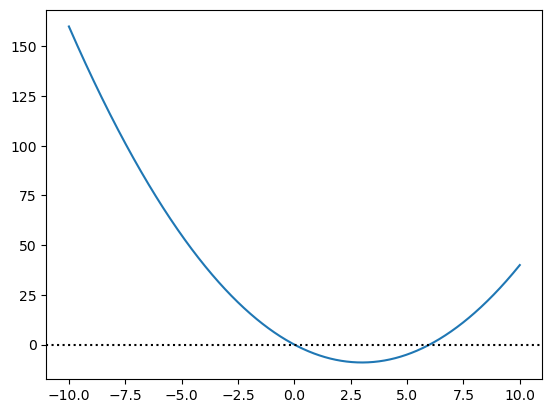

In [51]:
# define a test function
def f(x):
    return (x-3)**2 - 9

def df(x):
    return 2*(x-3)

def df2(x):
    return 2.

x = np.linspace(-10, 10, 1000)
plt.plot(x, f(x))
plt.axhline(0, c="k", ls=":")

In [52]:
root = newtons_method(f, df, x0=0.1)
print (f"root {root}, f(root) = {f(root)}")

interation 0
interation 1
interation 2
root -4.092847520435343e-14, f(root) = 2.4513724383723456e-13


In [53]:
minimum = newtons_method(df, df2, x0=0.1)
print (f"minimum {minimum}, f'(minimum) = {df(minimum)}")

interation 0
minimum 3.0, f'(minimum) = 0.0


There is an important qualifier in the statement about fixed points: **a root needs to exist in the vicinity of $x_0$!** If that's not the case, `newtons_method` will not terminate and come back with a result. You'd have to manually interrupt the execution of this method (Jupyer Tip: click "Interrupt Kernel"),

With a little more defensive programming we can make sure that the function will terminate after a given number of iterations. We'll also take out the print statement to make it faster and less messy.

In [54]:
def newtons_method2(f, df, x0, tol=1E-6, maxiter=100000):
    x_n = x0    
    for _ in range(maxiter):
        x_n = x_n - f(x_n)/df(x_n)
        if abs(f(x_n)) < tol:
            return x_n
        
    raise RuntimeError("Failed to find a minimum within {} iterations ".format(maxiter))

In [55]:
newtons_method2(f, df, x0=0.1)

-4.092847520435343e-14

## Using scipy.optimize

scipy comes with a pretty feature-rich [optimization package](https://docs.scipy.org/doc/scipy/reference/optimize.html), for one- and multi-dimensional optimization. As so often, it's better (as in faster and more reliable) to leverage exisiting and battle-tested code than to try to implement it yourself.

### Exercise 1:

Find the minimum of `f` with `scipy.optimize.minimize_scalar`. Look up the various arguments to function in the documentation (either online or by typing `scipy.optimize.minimize_scalar?`) and choose appropriate inputs. When done, visualize your result to confirm its correctness.

In [56]:
import scipy.optimize as cp

In [57]:
res = cp.minimize_scalar(f)

In [58]:
x_sol = res.x
y_sol = res.fun

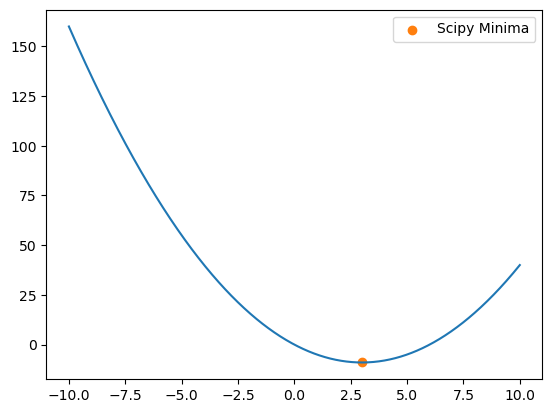

In [59]:
x = np.linspace(-10, 10, 1000)
plt.plot(x, f(x))
plt.scatter(x_sol, y_sol, color='C1', label="Scipy Minima")
plt.legend()

### Exercise 2:

To make this more interesting, we'll create a new  multi-dimensional function that resembles `f`:

In [60]:
def h(x, p):
    return np.sum(np.abs(x-3)**p, axis=-1) - 9

In 2D, find the minimum of `h` for `p=2` with `scipy.optimimze.minimize`. Note that you have not been given a derivative of `h`. You can choose to compute it analytically, or see if `minimize` has options that allow you to work without.

When done, visualize your result to confirm its correctness.

In [61]:
res2 = cp.minimize(h, args=2, x0=0)

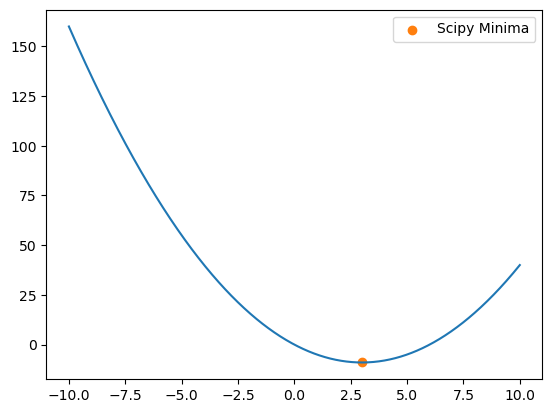

In [62]:
x = np.linspace(-10, 10, 1000)
plt.plot(x, f(x))
plt.scatter(res2.x, res2.fun, color='C1', label="Scipy Minima")
plt.legend()

### Exercise 3:

Experiment what happens if $p<1$. Do you understand why that happens? Can it be avoided?

yes, closer initial guess

In [63]:
res3 = cp.minimize(h, args=0.5, x0=2.5)

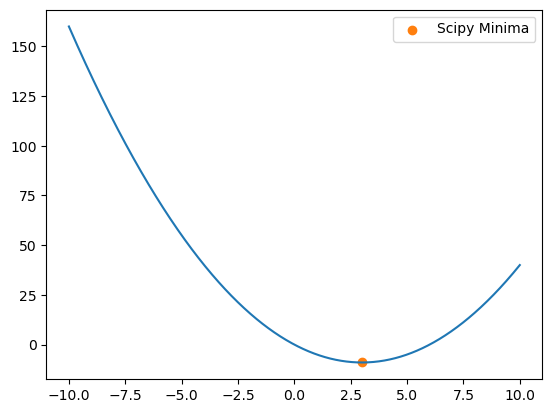

In [64]:
x = np.linspace(-10, 10, 1000)
plt.plot(x, f(x))
plt.scatter(res2.x, res2.fun, color='C1', label="Scipy Minima")
plt.legend()